## DTSA 5511 Introduction to Deep Learning
## Peer-graded Assignment: Week 5: GANs
## I'm Something of a Painter Myself
### 1.Brief description of the problem and data
### 1-1. Challenge problem

This is week 5 mini-project. I participate in the Kaggle competitions,<br>
 "I'm Something of a Painter Myself".<br>

https://www.kaggle.com/competitions/gan-getting-started

We recognize the works of artists through their unique style, such as color choices or brush strokes. In recent years the artists can now be imitated with algorithms thanks to generative adversarial networks (GANs). This challenge is to build a GAN that generates Monet-style images.

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import shutil
from kaggle_datasets import KaggleDatasets

I upload the photo dataset and the Monet dataset.

In [46]:
os.listdir('../input/gan-getting-started')

['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']

## 1-2. The size, dimension, structure, etc., of the data

I confirm the files in downloaded folder.

  I ckeck the number of .tfrec files.

In [49]:
MONET_TFREC_FILENAMES = tf.io.gfile.glob('../input/gan-getting-started/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_TFREC_FILENAMES))

PHOTO_TFREC_FILENAMES = tf.io.gfile.glob('../input/gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_TFREC_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


There are only 25 tfrec files in the downloaded folder.<br>
I ckeck the number of jpeg files.

In [50]:
MONET_FILENAMES = tf.io.gfile.glob('../input/gan-getting-started/monet_jpg/*.jpg')
print('MONET_Files:', len(MONET_FILENAMES))
PHOTO_FILENAMES = tf.io.gfile.glob('../input/gan-getting-started/photo_jpg/*.jpg')
print('PHOTO Files:', len(PHOTO_FILENAMES))

MONET_Files: 300
PHOTO Files: 7038


I check the size of image.

In [51]:
im_monet = cv2.imread(MONET_FILENAMES[0])
print(type(im_monet))
print("image size of Monet : ", im_monet.shape)

im_photo = cv2.imread(MONET_FILENAMES[0])
print(type(im_photo))
print("image size of Monet : ", im_photo.shape)

<class 'numpy.ndarray'>
image size of Monet :  (256, 256, 3)
<class 'numpy.ndarray'>
image size of Monet :  (256, 256, 3)


The dimension of Monet is 3. The size of Monet is 256*256.

# 2. Exploratory Data Analysis (EDA)

First, I show the image of .tfrec files.

MONETO TFRecord Files


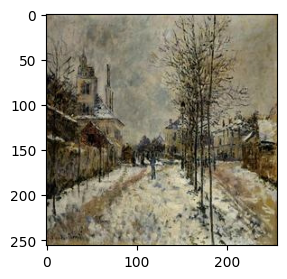

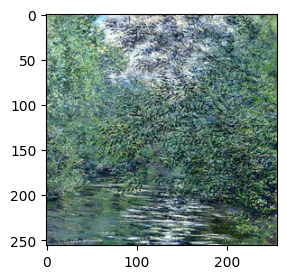

PHOTO TFRecord Files


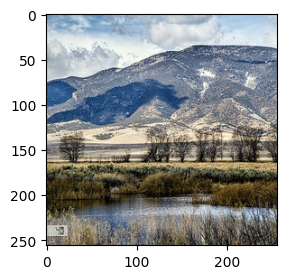

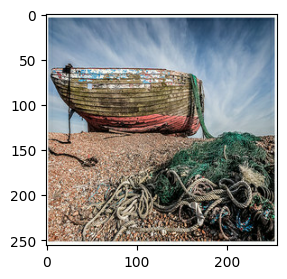

In [52]:
def display_images(sample):
    raw_image = next(iter(tf.data.TFRecordDataset([sample])))
    tfrecord_format = {"image_name": tf.io.FixedLenFeature([], tf.string),
                       "image": tf.io.FixedLenFeature([], tf.string),
                       "target": tf.io.FixedLenFeature([], tf.string)    }
    example = tf.io.parse_single_example(raw_image, tfrecord_format)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    img = image.numpy()
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plt.imshow(img)
    plt.show()

print('MONETO TFRecord Files')
display_images(MONET_TFREC_FILENAMES[0])
display_images(MONET_TFREC_FILENAMES[1])
print('PHOTO TFRecord Files')
display_images(PHOTO_TFREC_FILENAMES[0])
display_images(PHOTO_TFREC_FILENAMES[1])

I show the image of .jpg files.

In [ ]:
def display_images(sample):
    image = tf.io.read_file(sample)
    image = tf.image.decode_jpeg(image, channels=3)
    img = image.numpy()
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(img)
    plt.show()
    print("shape of jpg file : ", img.shape)

print('MONETO JEG Files')
display_images(MONET_FILENAMES[0])
display_images(MONET_FILENAMES[1])
display_images(MONET_FILENAMES[2])
print('MONET JPG Files:', len(MONET_FILENAMES))
print()
print('PHOTO JPG Files')
display_images(PHOTO_FILENAMES[0])
display_images(PHOTO_FILENAMES[1])
display_images(PHOTO_FILENAMES[2])
print('PHOTO JPG Files:', len(PHOTO_FILENAMES))

The images for the competition are sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale.

In [54]:
IMAGE_SIZE = [256, 256]
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

Define the function to extract the image from the files.

In [55]:
def load_dataset(filenames, labeled=True, ordered=False):
    AUTOTUNE = tf.data.AUTOTUNE   #何故か追加することになった
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(lambda x: decode_image(tf.io.read_file(x)), num_parallel_calls=AUTOTUNE)
    return dataset

I show a photo example and a Monet example.

In [56]:
def color_histograms_graph(image):
    plt.figure(figsize=(10, 3))
    for i, color in enumerate(['red', 'green', 'blue']):
        color_data = image[..., i].numpy().flatten()
        plt.subplot(1, 3, i+1)
        plt.hist(color_data, bins=256, color=color, alpha=0.6)
        plt.title(f'{color} color')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Modify the load_dataset function to handle JPG files
def load_dataset(filenames, labeled=True, ordered=False):
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(lambda x: decode_image(tf.io.read_file(x)), num_parallel_calls=AUTOTUNE)
    return dataset

# Separate dataset into batches of 32 images using the appropriate filenames and function call
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(5)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(5)
print("1", monet_ds)

1 <_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


I plot the color histograms for the Monet Painting images.

Color Distributions for Monet Paintings


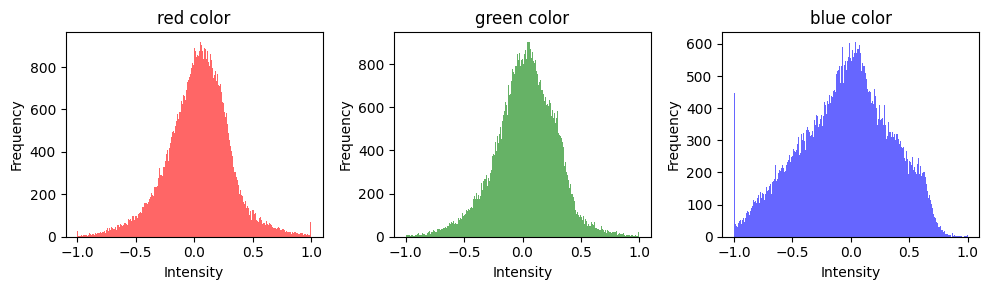

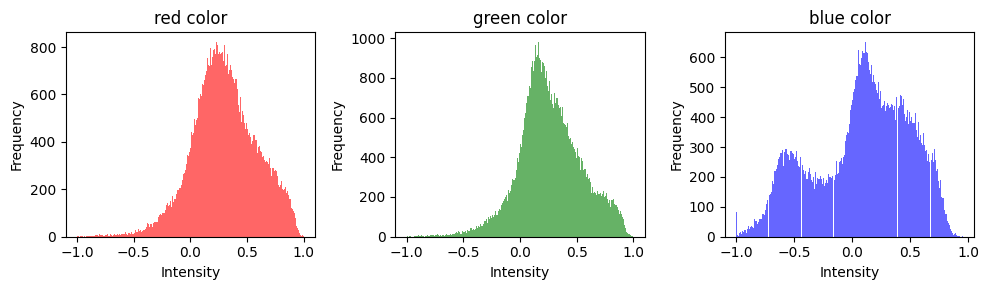

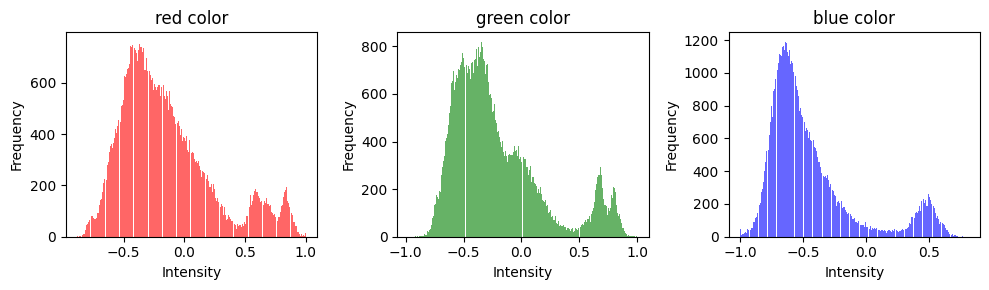

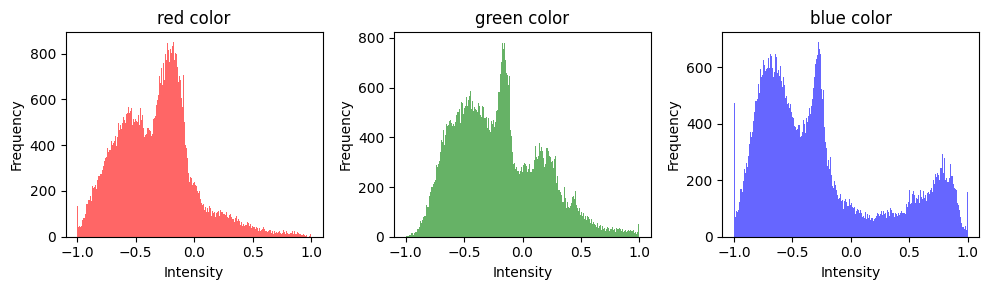

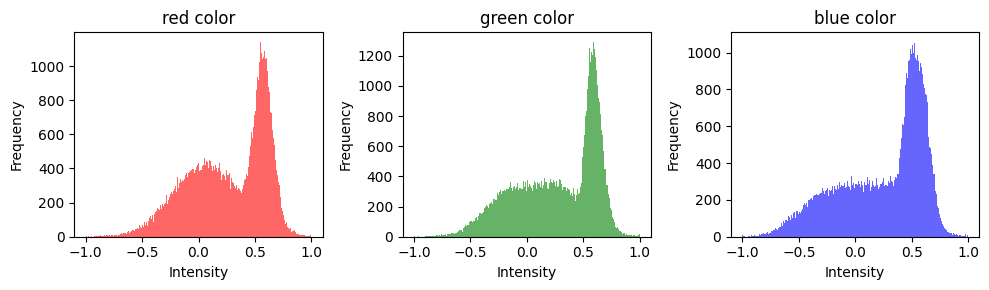

In [57]:
print('Color Distributions for Monet Paintings')
for image_batch in monet_ds.take(1):
    for image in image_batch:
        color_histograms_graph(image)

I plot the color histograms for the Photographs images.

Color Distributions for Photographs


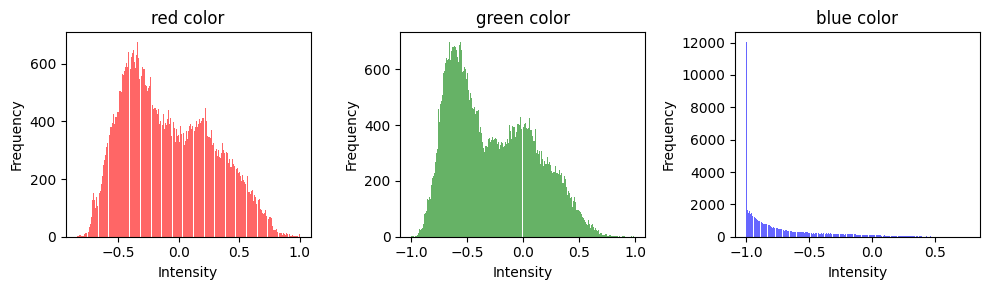

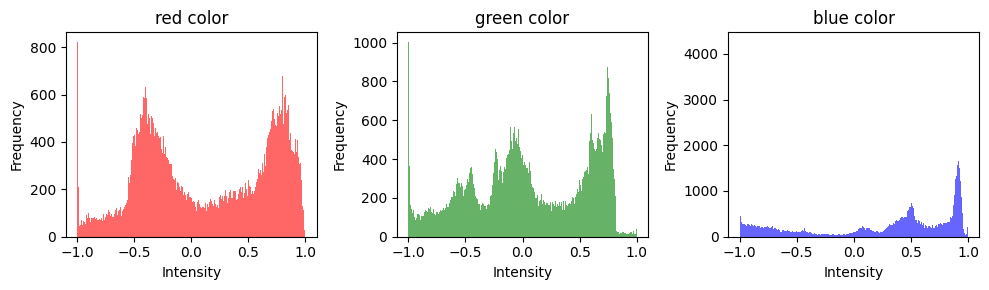

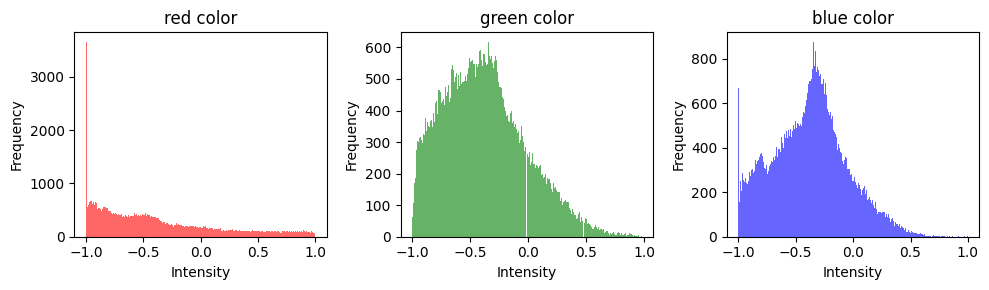

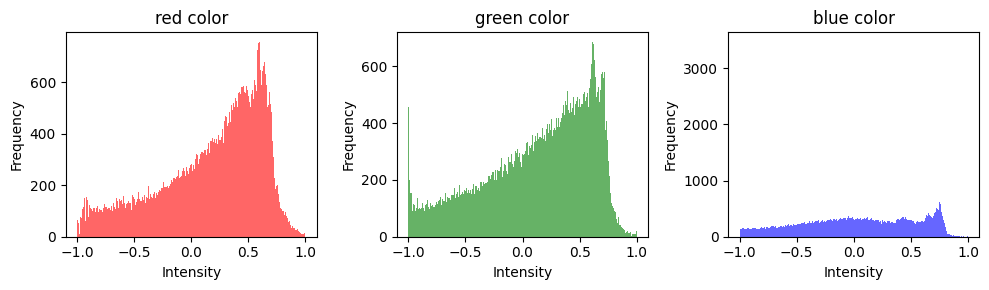

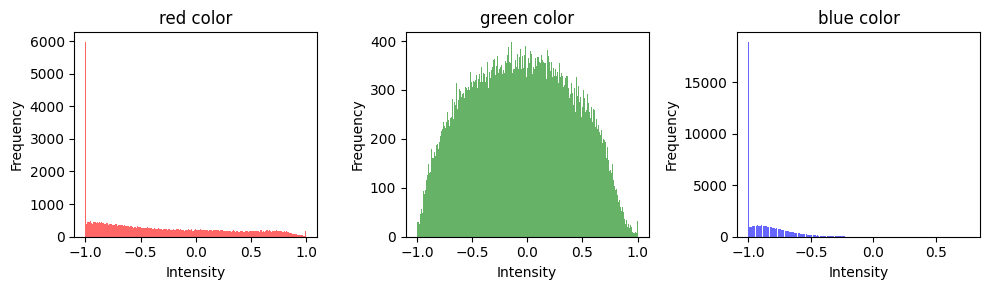

In [58]:
print('Color Distributions for Photographs')
for image_batch in photo_ds.take(1):
    for image in image_batch:
        color_histograms_graph(image)

I see the color intensity distribution of some Monet image and photo. Although I can not find specific charactor and differeance. I feel if I want to find out charactor I have to search all of Monet paint and perform statistical analysis. So I will proceed with this without cleaning and tuning.

# 3. Model Architecture

I use a CycleGAN method for creating pseudo-Monet paint. It utilizes both a generator and discriminator.

A GAN is learning model designed to generate realistic data by learning patterns from training datasets. A GAN architecture consists of two deep neural networks: the generator network and the discriminator network.
A GAN is designed to generate realistic data by learning datasets. A GAN architecture consists of two neural networks: "generator" and "discriminator". "generator" create data, for example images, based on noise, and try to make the imitatation of the given training set. "discriminator" evaluates the generated data set and decides whether it's real or fake. "generator" uses feedback from "discriminator" and trying to create more suitable data.

# 3.1 Discriminator and Generator

To excute efficient leraing, I use "downsample" and "upsample" method.
  
"downsample" reduces the 2D dimensions(width and height), of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, hence reduce the weight and height by 2.

"upsample" does the opposite of downsample and increases the dimensions of the of the image. Conv2DTranspose does the opposite of a Conv2D layer.

In [59]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

The discriminator takes in the input image and classifies it as real or not. Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [60]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)

    norm1 = layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=inp, outputs=last)

monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

The generator first downsamples the input image and then upsample while establishing long skip connections.

In [61]:
def Generator():
    down_stack = [downsample(64, 4, apply_batchnorm=False),
                  downsample(128, 4),
                  downsample(256, 4),
                  downsample(512, 4),
                  downsample(512, 4),
                  downsample(512, 4),
                  downsample(512, 4),
                  downsample(512, 4),]

    up_stack = [upsample(512, 4, apply_dropout=True),
                upsample(512, 4, apply_dropout=True),
                upsample(512, 4, apply_dropout=True),
                upsample(512, 4),
                upsample(256, 4),
                upsample(128, 4),
                upsample(64, 4),]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs = tf.keras.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

monet_generator = Generator()
photo_generator = Generator()

# 3.3 CycleGAN model

We will subclass a "tf.keras.Model".

During the training step, the model transforms a photo to a Monet painting and then back to a photo, twice-transformed photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss.

In [62]:
class CycleGan(tf.keras.Model):
    def __init__(self, monet_generator,     photo_generator,
                       monet_discriminator, photo_discriminator):
        super(CycleGan, self).__init__()
        self.monet_generator = monet_generator
        self.photo_generator = photo_generator
        self.monet_discriminator = monet_discriminator
        self.photo_discriminator = photo_discriminator

    def compile(self, m_gen_optimizer,   p_gen_optimizer,
                      m_disc_optimizer,  p_disc_optimizer,
                      gen_loss_fn,       disc_loss_fn,
                      cycle_loss_fn,     identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, data):
        real_monet, real_photo = data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.monet_generator(real_photo, training=True)
            cycled_photo = self.photo_generator(fake_monet, training=True)
            # monet to photo back to monet
            fake_photo = self.photo_generator(real_monet, training=True)
            cycled_monet = self.monet_generator(fake_photo, training=True)

            # generating itself
            same_monet = self.monet_generator(real_monet, training=True)
            same_photo = self.photo_generator(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.monet_discriminator(real_monet, training=True)
            disc_real_photo = self.photo_discriminator(real_photo, training=True)
            # discriminator used to check, inputing fake images
            disc_fake_monet = self.monet_discriminator(fake_monet, training=True)
            disc_fake_photo = self.photo_discriminator(fake_photo, training=True)

            # generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            # total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, LAMBDA_CYCLE) + self.cycle_loss_fn(real_photo, cycled_photo, LAMBDA_CYCLE)
            # total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, LAMBDA_IDENTITY)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, LAMBDA_IDENTITY)
            # discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.monet_generator.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.photo_generator.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.monet_discriminator.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.photo_discriminator.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.monet_generator.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.photo_generator.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.monet_discriminator.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.photo_discriminator.trainable_variables))

        return {"monet_gen_loss": total_monet_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss,
                "photo_disc_loss": photo_disc_loss}

# 3.2 Loss Functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The discriminator loss means the average of the real and generated loss

In [63]:
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 0.5

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [64]:
def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    total_disc_loss = (real_loss + fake_loss) * 0.5
    return total_disc_loss

The generator is required to make image that deceive the discriminator into thinking the generated image is real. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [65]:
def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

Ideally, the original photo and the twice-transformed photo is similar to each other. Thus, we calculate the cycle consistency loss be finding the average of their difference.

In [66]:
def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss1

The identity loss compares the image with its generator. If given a photo as input, we want it to generate the same image as the image of the inputted photo ideally. The identity loss compares the input with the output of the generator.

In [67]:
def identity_loss(real_image, same_image, lambda_identity):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * loss

# 3.4 Training CycleGAN

Let's compile our model. I used "tf.keras.Model" to build our CycleGAN, and I train our model.

I tune optimizing parameter.

In [68]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

monet_generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9)
photo_generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9)

monet_discrim_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9)
photo_discrim_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9)

In [69]:
cycle_gan_model = CycleGan(monet_generator,     photo_generator,
                           monet_discriminator, photo_discriminator)

cycle_gan_model.compile(m_gen_optimizer  = monet_generator_optimizer,
                        p_gen_optimizer  = photo_generator_optimizer,
                        m_disc_optimizer = monet_discrim_optimizer,
                        p_disc_optimizer = photo_discrim_optimizer,
                        gen_loss_fn   = generator_loss,
                        disc_loss_fn  = discriminator_loss,
                        cycle_loss_fn = calc_cycle_loss,
                        identity_loss_fn = identity_loss)

In [71]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# fitting model to monet and photo
cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=4)

Epoch 1/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 1499s 5s/step - monet_disc_loss: 0.7109 - monet_gen_loss: 3.5150 - photo_disc_loss: 0.7064 - photo_gen_loss: 3.5971
Epoch 2/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 1524s 5s/step - monet_disc_loss: 0.6980 - monet_gen_loss: 3.2677 - photo_disc_loss: 0.6981 - photo_gen_loss: 3.3271
Epoch 3/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 1533s 5s/step - monet_disc_loss: 0.6914 - monet_gen_loss: 3.0073 - photo_disc_loss: 0.6992 - photo_gen_loss: 3.0100
Epoch 4/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 1499s 5s/step - monet_disc_loss: 0.6891 - monet_gen_loss: 2.7684 - photo_disc_loss: 0.6890 - photo_gen_loss: 2.7594


# 4. Results and Analysis

I run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures.

I visualize my Monet-esque photos

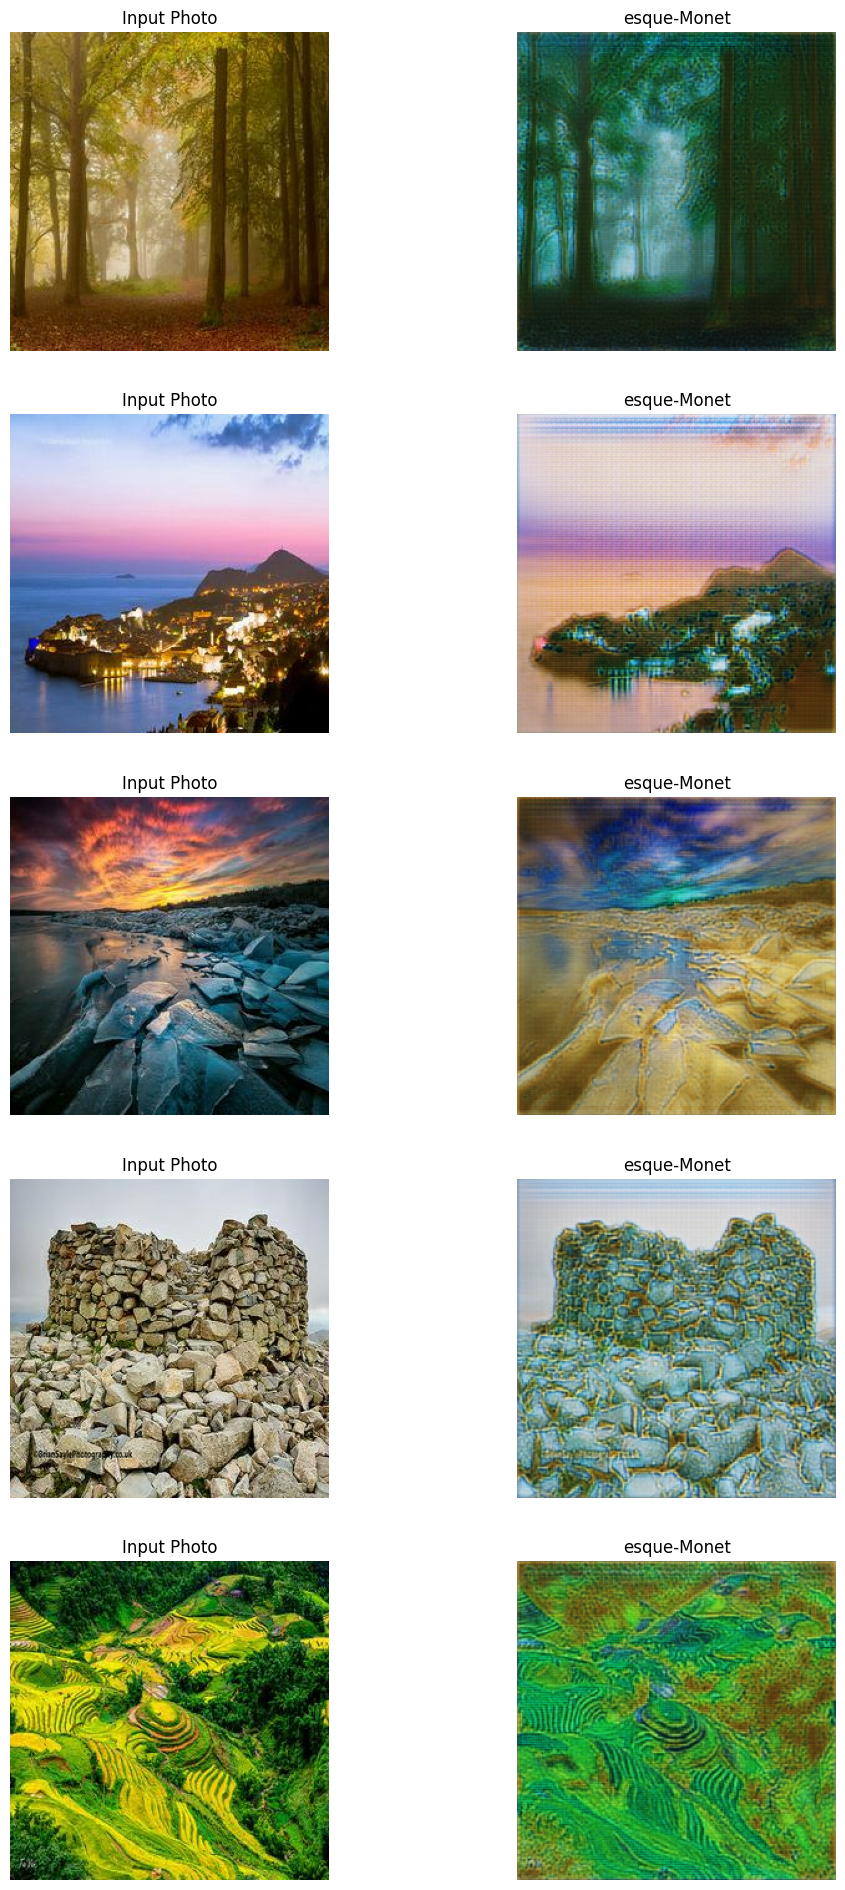

In [72]:
_, ax = plt.subplots(5, 2, figsize=(12, 24))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("esque-Monet")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# 6. conclusion

One of the idea to improve he code, chane the ratio of downsample and upsample, but it might consume the computor resouse.
At once grance, my generated image imitare Monet painting. Although they have the grid pattern. To eliminate this, I have to modify my code. It is furture work.

# 7. Produce Deliverables

I create submission file.

In [79]:
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

shutil.make_archive("/kaggle/working/images", 'zip', "/images")

mkdir: cannot create directory ‘../images’: File exists


'/kaggle/working/images.zip'

# End